In [2]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [6]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [7]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

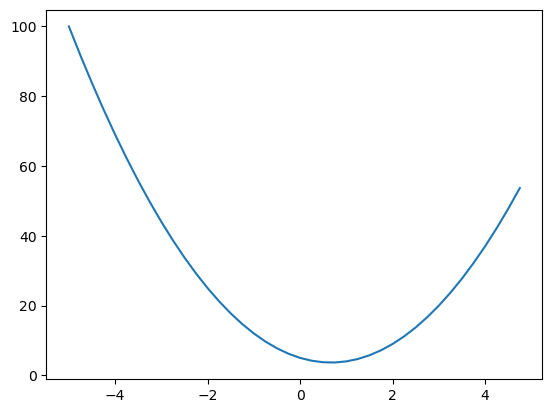

In [8]:
plt.plot(xs, ys)

In [24]:
h = 0.0001
x = 3.0

#This shows the amount of change in the slope of the function when we move from x to x + h.
print("Total slope change: ",(f(x + h) - f(x))) 

#This is the average rate of change of the function over the interval from x to x + h. 
# It gives us an approximation of the derivative of the function at x.
print("Avg rate of change: ",(f(x + h) - f(x)) / h)

Total slope change:  0.0014000300000063248
Avg rate of change:  14.000300000063248


In [26]:
#Getting more complex
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [30]:
h = 0.0001

#inputs
a = 2
b = -3
c = 10

d1 = a*b + c
c += h
d2 = a*b + c

print("d1: ", d1)
print("d2: ", d2)
print("Slope: ", (d2 - d1) /h)

d1:  4
d2:  4.0001
Slope:  0.9999999999976694


In [ ]:
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)
    

a = Value(2.0)
b = Value(-3.0)
print('a: ', a)
print('b: ', b)

#Internally calls a.__add__(b), where self is a and b is other.
print('a + b: ',a + b) 

print('a * b: ',a * b) 

#Now that we have both add and mul, we can do more complex things like (a * b) + c
c = Value(10.0)
print('(a * b) + c: ', (a * b) + c)

a:  Value(data = 2.0)
b:  Value(data = -3.0)
a + b:  Value(data = -1.0)
a * b:  Value(data = -6.0)
(a * b) + c:  Value(data = 4.0)


In [229]:
#Lets make it more complex

class Value:
    def __init__(self, data, _childen=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # This will hold the gradient of the value (change in slope with respect to the final output) during backpropagation.
        self._backward = lambda: None
        self._prev = set(_childen) #The set method prevents duplicate parents. 
        self._op = _op #Stores the operation used to create this value
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+") #Passing the children to the new value object in (self, other)
        
        def _backward():
            self.grad = 1 * out.grad
            other.grad = 1 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out


a = Value(2.0 , label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = (a * b); e.label = 'e' #Just the syntax for creating a new value object from an expression and then labeling it.
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print("d.prev: ", d._prev)
print("d._op: ", d._op)

d.prev:  {Value(data = 10.0), Value(data = -6.0)}
d._op:  +


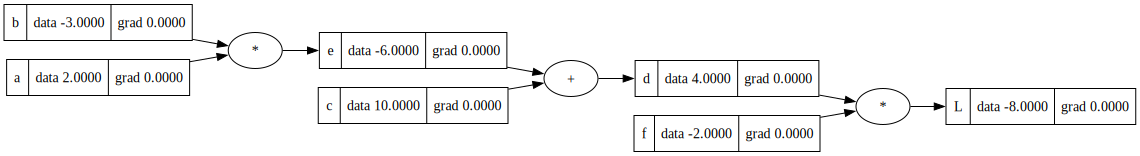

In [230]:
from graphviz import Digraph
# Simply a helper function to traverse the graph and collect all nodes and edges in a set, so we can visualize them later.
# Its purely for visualization purposes and has no effect on the actual backpropagation algorithm.

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

draw_dot(L)

In [231]:
# Manual backpropagation

# L = d * f
# dL/dd = f
d.grad = f.data

# So also, dl/df = d
f.grad = d.data

#Also if you think about it, d = e + c, so dd/de = 1 and dd/dc = 1
#Now we do our chain-rule aka backpropagation aka derivative multiplication

# dl/de = dl/dd * dd/de = f * 1.0
c.grad = d.grad * 1.0

# dl/dc = dl/dd * dd/dc = f * 1.0
e.grad = d.grad * 1.0

# You can notice that these plus nodes just copy the gradient to their inputs, they simply route back the gradient to their inputs.

# Now we have to go back to e = a * b, so de/da = b and de/db = a
# We also now know that dL/ de = -2.0, so we can calculate the gradients for a and b as well.

# dL/da = dL/de * de/da 
# dL/db = dL/de * de/db

a.grad = e.grad * b.data
b.grad = e.grad * a.data


In [232]:
# Testing values
a.data += a.grad * .01
b.data += b.grad * .01
c.data += c.grad * .01
f.data += f.grad * .01

# Re-running the forward pass with the new values to get the new output L.
e = a * b
d = e + c
L = d * f

print("L: ", L.data)

L:  -7.286496


Now here is the heart of the backpropagation algorithm
We need to calculate the gradients for c and e which are the parents of d, but d is not a leaf node

That is written as dd/dc and dd/de
These actual just end up being 1 because d = e + c, so dd/dc = 1 and dd/de = 1

But we need the derviative with respect to L not d.
So we can use the chain rule to calculate dL/dc and dL/de
All we need to do is multiply the derivatives together backwards from L to d and then to c and e.
BAM we are now backpropagating the gradients from L to d and then to c and e.

WANT:
dL / dc = (dL / dd) * (dd / dc)

KNOW:
dL / dd = -2
dd / dc = 1



In [233]:
L.grad = 1.0 #Manually setting the gradient of the final output to 1.0, since dL/dL = 1.0

In [234]:
def lol():
    h = 0.0001
    
    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = (a * b); e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data #Must say .data to reference the actual value of L, not the Value object itself.
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = (a * b); e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 -  L1) / h)

lol()
    

6.000000000021544


Congrats You've done the most basic backpropogation. Now its time for neurons

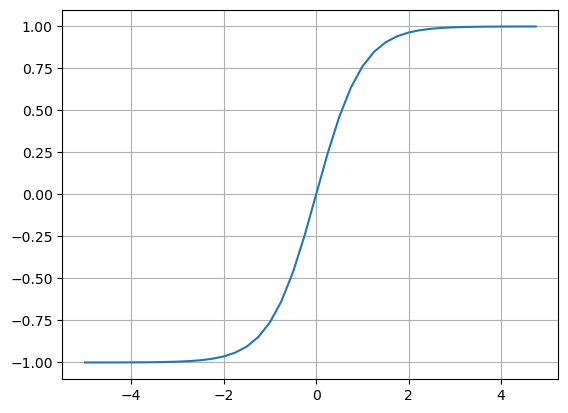

In [235]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))

plt.grid()

In [236]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# n is our activation function input
n = x1w1x2w2 + b; n.label = 'n'

#o is for output 
o = n.tanh(); o.label = 'o'


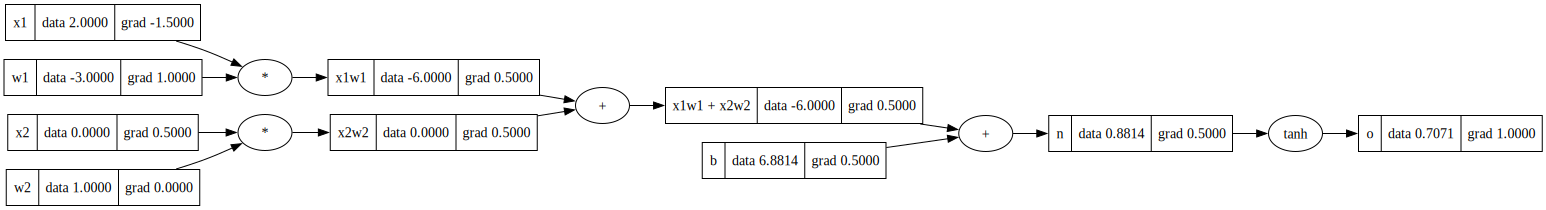

In [241]:
draw_dot(o)

In [240]:
#Automatic backpropagation

o.grad = 1.0
o._backward() #This will call the _backward function of o
n._backward()
b._backward() # Nothing happens here since b has no parents, but we call it for consistency

x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()


#These below dont do anything since x1, x2, w1, and w2 have no parents, but we call them for consistency.
x1._backward()
x2._backward()
w1._backward()
w2._backward()


In [196]:
#Lets do backpropagation on this neuron graph
o.grad = 1; # (since do/d0 = 1.0)

# o = tanh(n), so do/dn = 1 - tanh^2(n) OR JUST 1 - o^2
n.grad = o.grad * (1 - o.data ** 2)
print("n.grad: ", n.grad)

# n = x1w1x2w2 + b, so dn/dx1w1x2w2 = 1.0 and dn/db = 1.0
b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0

# x1w1x2w2 = x1w1 + x2w2, so dx1w1x2w2/dx1w1 = 1.0 and dx1w1x2w2/dx2w2 = 1.0
x1w1.grad = x1w1x2w2.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0

# x1w1 = x1 * w1, so dx1w1/dx1 = w1 and dx1w1/dw1 = x1
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

# x2w2 = x2 * w2, so dx2w2/dx2 = w2 and dx2w2/dw2 = x2
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad



n.grad:  0.4999999999999999
